In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
df = pd.read_csv('data/driving_log.csv')

In [3]:
df.shape

(8036, 7)

In [4]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


(array([  4.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.10000000e+01,   8.00000000e+01,
          1.80000000e+02,   2.14000000e+02,   8.11000000e+02,
          4.95600000e+03,   6.93000000e+02,   7.12000000e+02,
          1.76000000e+02,   1.28000000e+02,   3.80000000e+01,
          6.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([-0.9426954 , -0.84556063, -0.74842586, -0.65129109, -0.55415632,
        -0.45702155, -0.35988678, -0.26275201, -0.16561724, -0.06848247,
         0.0286523 ,  0.12578707,  0.22292184,  0.32005661,  0.41719138,
         0.51432615,  0.61146092,  0.70859569,  0.80573046,  0.90286523,  1.        ]),
 <a list of 20 Patch objects>)

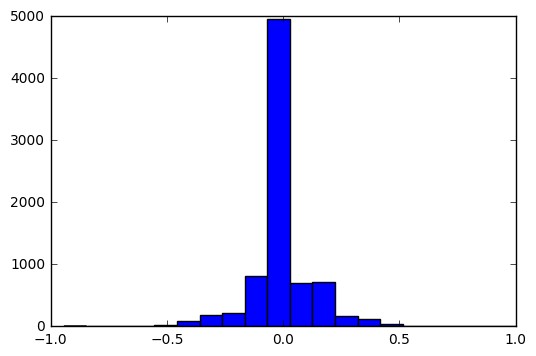

In [5]:
plt.hist(df['steering'], bins=20)

(array([  115.,    72.,    36.,    38.,    40.,    46.,    49.,    46.,
           48.,    59.,    61.,    45.,    51.,    48.,    39.,    50.,
           59.,    58.,    54.,  7022.]),
 array([  0.5024896 ,   2.01283312,   3.52317664,   5.03352016,
          6.54386368,   8.0542072 ,   9.56455072,  11.07489424,
         12.58523776,  14.09558128,  15.6059248 ,  17.11626832,
         18.62661184,  20.13695536,  21.64729888,  23.1576424 ,
         24.66798592,  26.17832944,  27.68867296,  29.19901648,  30.70936   ]),
 <a list of 20 Patch objects>)

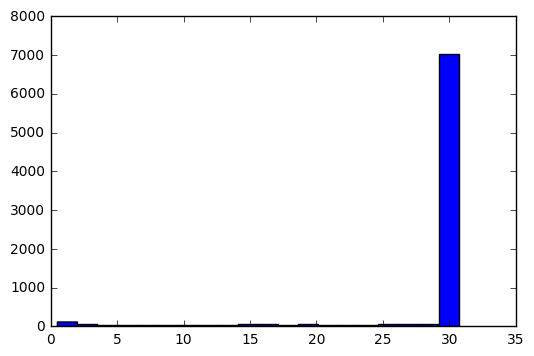

In [6]:
plt.hist(df['speed'], bins=20)

We see slight bias in steering to the right. Speed is basically always at max, which is not that high anyways.

In [7]:
imgc = mpimg.imread('data/' + df.iloc[0,0])

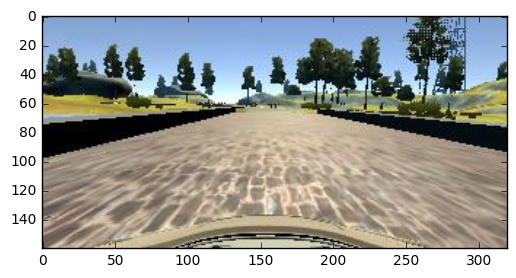

In [8]:
plt.imshow(imgc)

In [10]:
imgc.shape

(160, 320, 3)

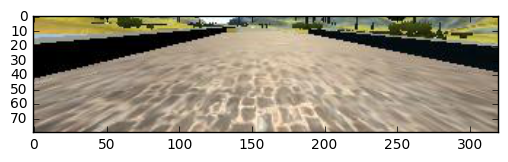

In [12]:
plt.imshow(imgc[55:135,:].astype(np.uint8))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [14]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

def get_session(gpu_fraction=0.8):
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())

Using TensorFlow backend.


In [15]:
def read_images(filenames, shape=(80,320,3)):
    ret = np.zeros((len(filenames),) + shape)
    for i,f in enumerate(filenames):
        buf = mpimg.imread(f)
        ret[i] = buf[55:135,:,:]
    return ret

def image_generator(Xnames, y, batch_size=128, use_shuffle=True):
    num_samples = len(Xnames)
    while 1:
        if use_shuffle:
            Xs, ys = shuffle(Xnames, y)
        for offset in range(0, num_samples, batch_size):
            yield read_images(Xs[offset:offset+batch_size]), ys[offset:offset+batch_size]

In [16]:
from keras.models import Model
from keras.layers import Input, Dense

In [17]:
input_layer = Input(shape=(80,320,3))

In [18]:
from keras.layers import Lambda

In [19]:
centered_input_layer = Lambda(lambda x: x/127.5-1., output_shape=(80,320,3))(input_layer)

In [20]:
from keras.layers import Conv2D

In [21]:
conv1 = Conv2D(16, 5, padding='same', activation='relu')(centered_input_layer)

In [22]:
conv2 = Conv2D(32, 5, padding='same', activation='relu')(conv1)

In [23]:
from keras.layers import MaxPool2D

In [24]:
pool1 = MaxPool2D()(conv2)

In [25]:
from keras.layers import Flatten

In [26]:
flatten = Flatten()(pool1)

In [27]:
output_layer = Dense(1)(flatten)

In [45]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile('adam','mse')

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 320, 16)       1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 320, 32)       12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 160, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 204801    
Total para

In [32]:
center_names = list('data/' + df['center'])

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(center_names, df['steering'].as_matrix(), test_size=0.2)

In [42]:
train_generator = image_generator(X_train, y_train, batch_size=256)
valid_generator = image_generator(X_valid, y_valid, batch_size=128)

In [43]:
model.fit_generator(train_generator, len(X_train), validation_data=valid_generator, validation_steps=1)

Epoch 1/1
 127/6428 [..............................] - ETA: 2295s - loss: 0.0057

KeyboardInterrupt: 

In [42]:
y_pred = model.predict(X_valid, batch_size=128)

In [50]:
np.stack([y_valid[:20],y_pred[:20,0]]).T

array([[ 0.0617599 ,  0.2364433 ],
       [ 0.04262284, -0.07362419],
       [-0.107229  , -0.06426191],
       [ 0.        ,  0.061385  ],
       [ 0.        ,  0.03104645],
       [ 0.3583844 ,  0.11473608],
       [ 0.        ,  0.0500754 ],
       [ 0.1670138 ,  0.10023993],
       [-0.00279104, -0.08095678],
       [ 0.3009732 ,  0.21913365],
       [ 0.        , -0.05416483],
       [ 0.05219137, -0.06985275],
       [ 0.        ,  0.03623541],
       [-0.06925154,  0.14433429],
       [-0.107229  ,  0.01026714],
       [ 0.1383082 ,  0.14317767],
       [ 0.1765823 ,  0.23956297],
       [-0.3445879 , -0.26652318],
       [ 0.        , -0.0277637 ],
       [ 0.        , -0.03696719]])

In [45]:
y_valid.shape

(1608,)

In [46]:
y_pred.shape

(1608, 1)

In [51]:
model.save('model.h5')

In [52]:
df['throttle'].describe()

count    8036.000000
mean        0.869660
std         0.301326
min         0.000000
25%         0.985533
50%         0.985533
75%         0.985533
max         0.985533
Name: throttle, dtype: float64